## Showing how Activations Affect Energy 

### Activations 
* ReLU 
* LeakyReLU (a = 0.25)
* Softplus 
* Sigmoid 
* Tanh 
    
### Process 
* Sample from two multivariate Gaussian distributions. One with a tiny variance (center), and the other with a large variance (sphere). 
* Increase the variance of the center sample over time to visualize the change: energy(center) - energy(sphere) 
* Over time, the energy difference between the two samples should decrease (their energy levels should converge). 

In [137]:
import torch
from torch import nn

import numpy as np
import matplotlib.pyplot as plt

In [152]:
class EnergyModel(nn.Module):
    def __init__(self, size, type = 'relu'):
        super(EnergyModel, self).__init__()
        self.size = size
        self.lr = 0.0001
        self.type = type

        # initialize energy model parameters theta
        hidden_size = 256 

        self.run_relu = nn.Sequential(
            nn.Linear(self.size, hidden_size),
            nn.ReLU(),
        )

        self.run_tanh = nn.Sequential(
            nn.Linear(self.size, hidden_size),
            nn.Tanh(),
        )

        self.run_softplus = nn.Sequential(
            nn.Linear(self.size, hidden_size),
            nn.Softplus(),
        )

        self.run_sigmoid = nn.Sequential(
            nn.Linear(self.size, hidden_size),
            nn.Sigmoid(),
        )

        self.run_leakyrelu = nn.Sequential(
            nn.Linear(self.size, hidden_size),
            nn.LeakyReLU(0.25),
        )

        self.optim = torch.optim.Adam(self.parameters(), lr = self.lr)


    # careful to add activation or else it becomes regular linear multiplication
    def forward(self, x):
        if self.type == 'tanh':
            x = self.run_tanh(x)
        elif self.type == 'softplus':
            x = self.run_softplus(x)
        elif self.type == 'leaky_relu':
            x = self.run_leakyrelu(x)
        elif self.type == 'sigmoid':
            x = self.run_sigmoid(x)
        else:
            x = self.run_relu(x)

        return x


    # energy function
    def U(self, x):
        return -1.0 * self.forward(x).sum()


    def go(self, data1, data2, epoch, energy_diff):
        self.train()

        x_pos = torch.autograd.Variable((torch.tensor(data1, dtype = torch.float32)),
                requires_grad = True)
        x_neg = torch.autograd.Variable((torch.tensor(data2, dtype = torch.float32)),
                requires_grad = True)

        self.optim.zero_grad()
        loss = self.U(x_neg) - self.U(x_pos) 
        loss.backward()
        self.optim.step() # updating parameters
        self.eval()
        
        # center - sphere 
        energy_diff.append(self.U(x_neg).detach() - self.U(x_pos).detach() )
        
        # print("Loss: ", loss.data)


In [155]:
def visualize_diff(data, epoch):
    plt.figure(2)
    plt.clf()
    data_diff = []
    
    for i in range(0, len(data) - 1):
        data_diff.append(data[i+1] - data[i])
        
    # durations_t = torch.tensor(data_diff, dtype=torch.float)
    plt.title('Energy Change vs. Variance')
    plt.xlabel('Variance Percentage')
    plt.ylabel('Energy')

    plt.plot(np.arange(0, 1, 1/epoch)[0:len(data_diff)], data_diff)
    plt.show()


def visualize_data(data, epoch):
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(data, dtype=torch.float)
    plt.title('Energy Change vs. Variance')
    plt.xlabel('Variance')
    plt.ylabel('Energy')

    plt.plot(np.arange(0, 1, 1/epoch), durations_t.numpy())
    plt.show()

In [140]:
size = 500
epoch = 300

dim = 100 
mean_arr1 = np.zeros(dim)
mean_arr2 = np.zeros(dim)
cov = np.identity(dim) * 10 
cov2 = np.identity(dim) * 10 


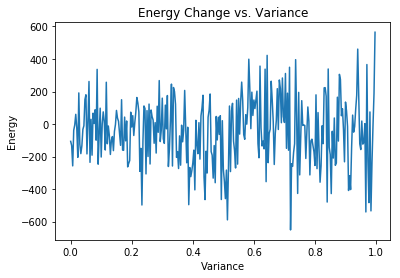

In [156]:
model = EnergyModel(size, 'tanh')
energy = []

for i in range(epoch):
    center = np.random.multivariate_normal(mean_arr1, cov * (i/epoch) , size)
    center = center.transpose()

    sphere = np.random.multivariate_normal(mean_arr2, cov2, size)
    sphere = sphere.transpose()

    model.go(sphere, center, i, energy)


visualize_data(energy, epoch)

# visualize_diff(energy, epoch) 

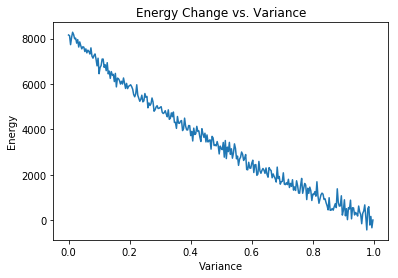

In [157]:
model = EnergyModel(size, 'softplus')
energy = []


for i in range(epoch):
    center = np.random.multivariate_normal(mean_arr1, cov * (i/epoch) , size)
    center = center.transpose()

    sphere = np.random.multivariate_normal(mean_arr2, cov2, size)
    sphere = sphere.transpose()

    model.go(sphere, center, i, energy)


visualize_data(energy, epoch)

# visualize_diff(energy, epoch) 

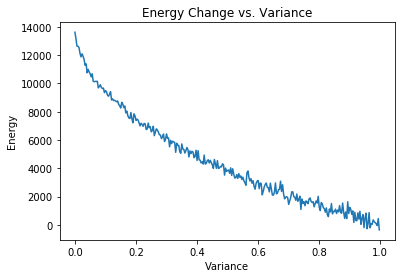

In [158]:
model = EnergyModel(size, 'leaky_relu')
energy = []


for i in range(epoch):
    center = np.random.multivariate_normal(mean_arr1, cov * (i/epoch) , size)
    center = center.transpose()

    sphere = np.random.multivariate_normal(mean_arr2, cov2, size)
    sphere = sphere.transpose()

    model.go(sphere, center, i, energy)


visualize_data(energy, epoch)

# visualize_diff(energy, epoch) 

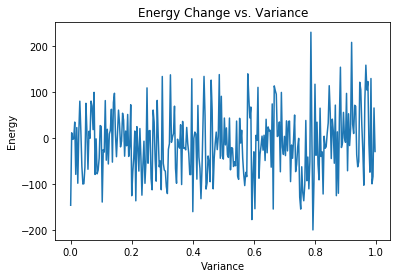

In [159]:
model = EnergyModel(size, 'sigmoid')
energy = []


for i in range(epoch):
    center = np.random.multivariate_normal(mean_arr1, cov * (i/epoch) , size)
    center = center.transpose()

    sphere = np.random.multivariate_normal(mean_arr2, cov2, size)
    sphere = sphere.transpose()

    # Now, either train the model and start a negative sample from the origin.
    # Will it travel all the way to the positive samples near the sphere?
    # For softplus() it should be the case, for relu() not.
    model.go(sphere, center, i, energy)


visualize_data(energy, epoch)

# visualize_diff(energy, epoch) 

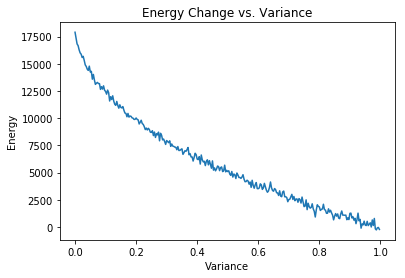

In [160]:
model = EnergyModel(size) # relu 
energy = []


for i in range(epoch):
    center = np.random.multivariate_normal(mean_arr1, cov * (i/epoch) , size)
    center = center.transpose()

    sphere = np.random.multivariate_normal(mean_arr2, cov2, size)
    sphere = sphere.transpose()

    model.go(sphere, center, i, energy)


visualize_data(energy, epoch)

# visualize_diff(energy, epoch) 